* Student ID: **46210288**
* Student name: **Le Nga Ho**
* Portfolio Github repo URL: https://github.com/MQCOMP6200/portfolio-s1-2021-lengaho

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

# Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# Create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# Look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# Add this to the book dataframe and then select only those rows that have a genre label
# Drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

print(genre_books.shape)
print(genre_books.head())

(8954, 5)
                  title             author        date  \
0           Animal Farm      George Orwell  1945-08-17   
1    A Clockwork Orange    Anthony Burgess        1962   
2            The Plague       Albert Camus        1947   
4  A Fire Upon the Deep       Vernor Vinge               
6  A Wizard of Earthsea  Ursula K. Le Guin        1968   

                                             summary                  genre  
0   Old Major, the old boar on the Manor Farm, ca...  Children's literature  
1   Alex, a teenager living in near-future Englan...                  Novel  
2   The text of The Plague is divided into five p...                  Novel  
4   The novel posits that space around the Milky ...                Fantasy  
6   Ged is a young boy on Gont, one of the larger...                Fantasy  


In [4]:
# Check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


**Comment:** The dataset is quite imbalanced, especially for the number of children's literature books. The ratio between **Fantasy** genre with the largest number of books versus **Children's literature** with the least books is 2311/1092 ~ **2.12**.

## Feature Exaction

Perform feature extraction to produce feature vectors for the predictive models.

### Determine extracted summary as the predictors - X

In [5]:
# Convert word to tfidf with optimisation
vectorizer = TfidfVectorizer(max_features=20000, min_df=5, stop_words='english')
X = vectorizer.fit_transform(genre_books.summary)
print(X.shape)

(8954, 20000)


**Note:** 
`min_df` = the minimum number (or percentage) of documents that contain the word. It is used to eliminate insignificant predictors (e.g. words that are misspelled or unique to one book)

### Determine target genres as the response - Y

In [6]:
# Map target genres to numerical values
category = ["Children's literature", 'Science Fiction', 'Novel', 'Fantasy', 'Mystery']
index = dict(zip(category,range(len(category))))
print(index)

# Map the day_of_week to the required index
genre_books['genre_id'] = genre_books['genre']
genre_books['genre_id'] = genre_books['genre_id'].map(index)

genre_books.head()

{"Children's literature": 0, 'Science Fiction': 1, 'Novel': 2, 'Fantasy': 3, 'Mystery': 4}


,title,author,date,summary,genre,genre_id
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,2
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,2
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,3
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,3


In [7]:
y = genre_books['genre_id']

## Model Training

Train (at least) two predictive models from the given data set.
* Logistic regression
* Naive Bays classification - Multinomial, Bernoulli, Complement

In [8]:
# Split the data into training(80%) and testing data(20%) and use random_state=142
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (7163, 20000) (7163,)
Test: (1791, 20000) (1791,)


In [9]:
# Define a modelling function with train & test execution time
def modelling(model):
    print('_' * 80)
    print("Training: ")
    print(model)
    
    # fit the model to the train set
    t0 = time()
    model.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    # predict on the test set
    t0 = time()
    y_pred = model.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

In [10]:
models = (LogisticRegression(max_iter=250), MultinomialNB(alpha=.1), BernoulliNB(alpha=.1), ComplementNB(alpha=.1))
for model in models:
    modelling(model)

________________________________________________________________________________
Training: 
LogisticRegression(max_iter=250)
train time: 1.959s
test time:  0.000s
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.1)
train time: 0.016s
test time:  0.016s
________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.1)
train time: 0.016s
test time:  0.016s
________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.016s
test time:  0.000s


**Comment:**
Among all models, logistic regression model takes the longest time to train. Meanwhile, Naive Bayes models take much less time to train.

## Model Evaluation

Finally, evaluate and compare the learned predictive models.

### Accuracy score

In [11]:
# Define a function for evaluating accuracy score
def accuracy(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)      
    
    return accuracy_score(y_test,y_pred)    

# Create a table comparing accuracy score
rows = []
for model in models:
    rows.append([model, accuracy(model)])

performance = pd.DataFrame(rows, columns=['Model', 'Accuracy score'])
performance

,Model,Accuracy score
0,LogisticRegression(max_iter=250),0.696259
1,MultinomialNB(alpha=0.1),0.694026
2,BernoulliNB(alpha=0.1),0.627582
3,ComplementNB(alpha=0.1),0.690117


**Comment:**
Comparing the accuracy scores between models:
* **Logistic Regression** has the best performance with the rate of 69.63%.
* **Bernoulli Naive Bayes** has the lowest correct prediction percebtage of 62.40%.
* Among three Naive Bayes models, the **Multinomial** model has the highest accuracy score being 69.40%.

Nevertheless, with the accuracy score below 70%, all models are not doing well. To increase the performance, more features (e.g. author) and better tuning should be added. Additionally, more processing on text can be done to improve prediction based on words.

### Confusion matrix

The confusion matrix will be visualised to provide the detailed outputs of the predictive models.

In [12]:
# Define a function that returns confusion matrix
def cm(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)        
    
    return confusion_matrix(y_test,y_pred)

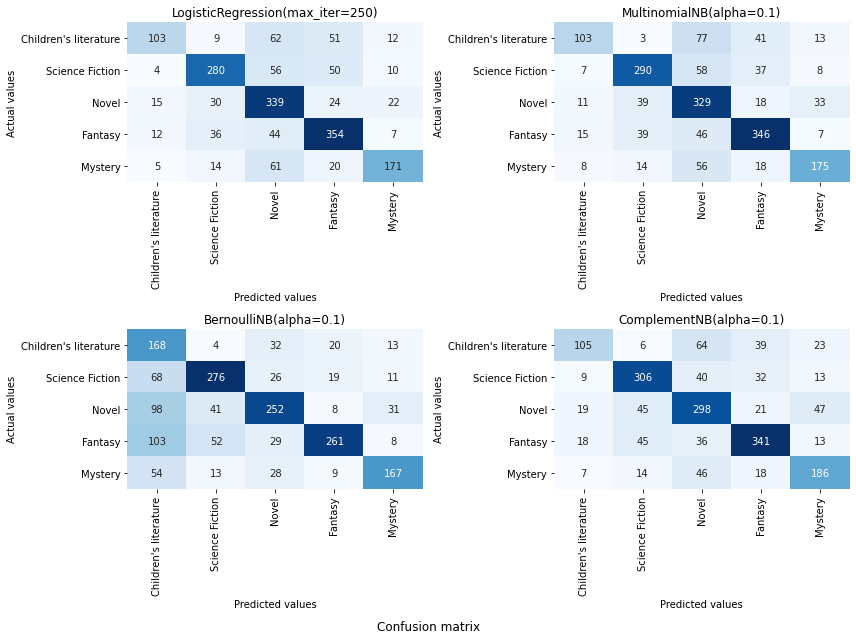

In [13]:
# Plot the heat maps
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for model, ax in zip(models, axes.flatten()):
    sns.heatmap(cm(model), xticklabels=category, yticklabels=category, annot=True, cmap="Blues", fmt='d', cbar=False, ax=ax)
    ax.set(xlabel='Predicted values', ylabel='Actual values', title = model)

fig.suptitle('Confusion matrix', y=0)
fig.tight_layout()
plt.show()

**Comment:**
* General interpretation (for each class/genre):
    * **Total actual values** = Sum Positive = True Positive (TP) + False Positive (FP) ~ sum of the row
    * **Total predicted value** = True Positive (TP) + False Negative (NP) ~ sum of the column
    * **True Positive (TP)** = actual values that are correctly predicted as true ~ when predicted values match actual values
    * **False Positive (FP)** = actual values that are wrongly predicted as false
    * **False Negative (FN)** = other values that are wrongly predicted as true ~ when predicted values are not actual values
    * **True Negative (TN)** = other values that are correctly predicted as false

* A sample interpretation of predicting **Children's literature** genre by **Logistic Regression**:
    * TP = 103; FP = 9+62+51+12 = 134; FN = 4+15+12+5 = 36
    * The model correctly classifies 103 books of Children genre out of its total 139 (103+36) predictions for this genre. The model's precision rate for the Children genre is 74.10% (103/139).
    * The model only identifies 103 Children books out of the total 237 (103+134) Children books. The accuracy score of the model for the Children genre is 43.46% (103/237).
    
* The confusion matrix will be interpreted in percentage in the **classification report**.
    * **Precision** = Correctly predicted actual values/total predicted values (or = TP/(TP + FP))
    * **Recall** = Correctly predicted actual values/total actual values (or = TP/(TP + FN))

### Classification report

The discussion will be focused on the classification reports of the top 2 best performing models - Logistic Regression and Multinomial Naive Bayes. Some notations:
* **Precision** = Correctly predicted actual values/total predicted values (or = TP/(TP + FP))    
* **Recall** = Correctly predicted actual values/total actual values (or = TP/(TP + FN))    
* **Accuracy score** = weighted average of Recall score    
* **F1 score** is the weighted average of Precision and Recall, taking both false positives and false negatives into account. This can be more useful than accuracy score when there is an imbalanced class distribution.

In [14]:
# Define a function for producing classification report
def report(model):
    print("Classification report:")
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    table = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    
    return table

In [15]:
# Logistic Regression
report(LogisticRegression(max_iter=250))

Classification report:
LogisticRegression(max_iter=250)


,precision,recall,f1-score,support
0,0.741007,0.434599,0.547872,237.000000
1,0.758808,0.700000,0.728218,400.000000
2,0.603203,0.788372,0.683468,430.000000
3,0.709419,0.781457,0.743697,453.000000
4,0.770270,0.630996,0.693712,271.000000
accuracy,0.696259,0.696259,0.696259,0.696259
macro avg,0.716541,0.667085,0.679394,1791.000000
weighted avg,0.708336,0.696259,0.692303,1791.000000


**Comment:** 
* Logistic Regression (max_iter=250) model has the highest precision for prediction Mystery(4) genre at 77.03% and the highest accuracy scores for Novel(2) genre at 78.84% and Fantasy(3) at 78.15%.
* However, the model has much better F1-scores (over 72%) for Fantasy(3) and Science Fiction(1) which have both the precision and recall rates above 70.00%.
* Children's literature (0) sees the worst performance for both recall and f1-score.

In [16]:
# MultinomialNB
report(MultinomialNB(alpha=0.1))

Classification report:
MultinomialNB(alpha=0.1)


,precision,recall,f1-score,support
0,0.715278,0.434599,0.540682,237.000000
1,0.753247,0.725000,0.738854,400.000000
2,0.581272,0.765116,0.660643,430.000000
3,0.752174,0.763797,0.757941,453.000000
4,0.741525,0.645756,0.690335,271.000000
accuracy,0.694026,0.694026,0.694026,0.694026
macro avg,0.708699,0.666854,0.677691,1791.000000
weighted avg,0.704888,0.694026,0.691339,1791.000000


**Comment:** 
* MultinomialNB(alpha=0.1) model performs best in Fantasy(3) and Science Fiction(1) genres.
* Fantasy(3) prediction has the highest F1-score of 75.91%, scoring the second best in both precision and recall rates at over 75%. 
* Science Fiction(1) category which ranks second in F1-score has the best precision of 75.32% and a high recall rate of 72.50%.
* However, Novel(2) is the genre with the highest accuracy score of 76.51% and the worst precision rate.
* Meanwhile, Children's literature (0) continues to see the lowest in both recall and f1-score.

In [17]:
# Overview of classification reports of all models
for model in models:
    print('_' * 80)
    print("Classification report:")
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    print(classification_report(y_test, y_pred))

________________________________________________________________________________
Classification report:
LogisticRegression(max_iter=250)
              precision    recall  f1-score   support

           0       0.74      0.43      0.55       237
           1       0.76      0.70      0.73       400
           2       0.60      0.79      0.68       430
           3       0.71      0.78      0.74       453
           4       0.77      0.63      0.69       271

    accuracy                           0.70      1791
   macro avg       0.72      0.67      0.68      1791
weighted avg       0.71      0.70      0.69      1791

________________________________________________________________________________
Classification report:
MultinomialNB(alpha=0.1)
              precision    recall  f1-score   support

           0       0.72      0.43      0.54       237
           1       0.75      0.72      0.74       400
           2       0.58      0.77      0.66       430
           3       0.75     

**General trends:** 
* **Fantasy** and **Science Fiction** are the two best predicted genres by all models. One possible explanation for this might be that these two genres have more distinct keywords compared to the remaining genres.
* On the other hand, **Children's Literature** is the most misclassified one. This might be due to the genre having much smaller number of samples compared to other genres in the data set and having fewer distinguished keywords.

## Conclusion

This portfolio aims to build predictive models from the CMU Book Summaries dataset and classify the books into one of the five target genres: Children's Literature, Science Fiction, Novel, Fantasy and Mystery. First, the dataset is filtered to only include one target genre label per book. Next, book summaries are converted from the text format to the more suitable word features using `TfidfVectorizer`. Then, the **Logistic regression** and **Naive Bayes models (Multinomial, Bernoulli & Complement)** are selected to be built on the training set and make predictions on the testing set. Finally, the models are evaluated and compared through several metric scores on their performances in prediction.

Overall, **Logistic Regression** has the best performance with an accuracy score of 69.63%, followed by **Multinomial Naive Bayes** classifier doing better than the other two Naive Bayes models. However, logistic model takes the longest time to train while all Naive Bayes models spend much less time to execute.

In general, **Fantasy** and **Science Fiction** genres are most accurately predicted by all models, whereas **Children's Literature** sees the poorest performance. The difference in accuracy may be due to Fantasy and Science Fiction books having more distinct keywords than the other genres, and Children books being a minority class in the data set.

Nonetheless, all models are not yet a good fit with the accuracy score below 70%. More features, such as the author's name and book's title, and better tuning may be added to improve the prediction. In addition, text can be further processed to increase performance based on words.